
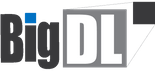
---

In [ ]:
pip install pyvi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.5 MB 6.9 MB/s 
     |████████████████████████████████| 965 kB 39.8 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Environment Preparation**

**Install Java 8**

Run the cell on the **Google Colab** to install jdk 1.8.

**Note:** if you run this notebook on your computer, root permission is required when running the cell to install Java 8. (You may ignore this cell if Java 8 has already been set up in your computer).


In [ ]:
# Install jdk8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
# Set environment variable JAVA_HOME.
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode
openjdk version "1.8.0_312"
OpenJDK Runtime Environment (build 1.8.0_312-8u312-b07-0ubuntu1~18.04-b07)
OpenJDK 64-Bit Server VM (build 25.312-b07, mixed mode)


**Install BigDL Orca**

You can install the latest pre-release version using `pip install --pre --upgrade bigdl-orca`. 

In [ ]:
# Install latest pre-release version of BigDL Orca 
# Installing BigDL Orca from pip will automatically install pyspark, bigdl, and their dependencies.
!pip install --pre --upgrade bigdl-orca[ray]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 23.9 MB 1.2 MB/s 
     |████████████████████████████████| 71.0 MB 405 bytes/s 
     |████████████████████████████████| 35.4 MB 407 kB/s 
     |████████████████████████████████| 51.8 MB 70 kB/s 
     |████████████████████████████████| 85 kB 4.1 MB/s 
     |████████████████████████████████| 1.1 MB 49.8 MB/s 
     |████████████████████████████████| 65 kB 4.0 MB/s 
     |████████████████████████████████| 57.6 MB 1.3 MB/s 
     |████████████████████████████████| 144 kB 59.5 MB/s 
     |████████████████████████████████| 271 kB 50.8 MB/s 
     |████████████████████████████████| 94 kB 4.1 MB/s 
     |████████████████████████████████| 218.4 MB 46 kB/s 
     |████████████████████████████████| 51.0 MB 67 kB/s 
     |████████████████████████████████| 197 kB 50.5 MB/s 
     |████████████████████████████████| 246 kB 50.0 MB/s 
     |██████████████████████████████

## **Distributed TensorFlow 2 using Orca APIs**

In this guide we will describe how to scale out TensorFlow 2 programs using Orca in 4 simple steps.

In [ ]:
# import necesary libraries and modules
import argparse

from bigdl.orca import init_orca_context, stop_orca_context
from bigdl.orca import OrcaContext

### **Step 1: Init Orca Context** 

In [ ]:
# recommended to set it to True when running BigDL in Jupyter notebook 
OrcaContext.log_output = True # (this will display terminal's stdout and stderr in the Jupyter notebook).

cluster_mode = "local"

if cluster_mode == "local":  
    init_orca_context(cluster_mode="local", cores=1) # run in local mode
elif cluster_mode == "k8s":  
    init_orca_context(cluster_mode="k8s", num_nodes=2, cores=2) # run on K8s cluster
elif cluster_mode == "yarn":  
    init_orca_context(cluster_mode="yarn-client", num_nodes=2, cores=2) # run on Hadoop YARN cluster

Initializing orca context
Current pyspark location is : /usr/local/lib/python3.7/dist-packages/pyspark/__init__.py
Start to getOrCreate SparkContext
pyspark_submit_args is:  --driver-class-path /usr/local/lib/python3.7/dist-packages/bigdl/share/orca/lib/bigdl-orca-spark_2.4.6-2.1.0-SNAPSHOT-jar-with-dependencies.jar:/usr/local/lib/python3.7/dist-packages/bigdl/share/dllib/lib/bigdl-dllib-spark_2.4.6-2.1.0-SNAPSHOT-jar-with-dependencies.jar:/usr/local/lib/python3.7/dist-packages/bigdl/share/core/lib/all-2.1.0-20220314.094552-2.jar pyspark-shell 
Successfully got a SparkContext


This is the only place where you need to specify local or distributed mode. View [Orca Context](https://bigdl.readthedocs.io/en/latest/doc/Orca/Overview/orca-context.html) for more details.

**Note**: You should export HADOOP_CONF_DIR=/path/to/hadoop/conf/dir when you run on Hadoop YARN cluster.

### **Step 2: Define the Model**

You can then define the Keras model in the *Creator Function* using the standard TensroFlow 2 APIs.

In [ ]:
import pandas as pd 
import numpy as np 

DATA = '/content/drive/MyDrive/Colab/BigData/vihsd/train.csv'
DEV_DATA = '/content/drive/MyDrive/Colab/BigData/vihsd/dev.csv'
TEST_DATA = '/content/drive/MyDrive/Colab/BigData/vihsd/test.csv'

# read data
train_data = pd.read_csv(DATA)
dev_data = pd.read_csv(DEV_DATA)
test_data = pd.read_csv(TEST_DATA)

X_train = train_data['free_text']
y_train = train_data['label_id'].values

X_dev = dev_data['free_text']
y_dev = dev_data['label_id'].values

X_test = test_data['free_text']
y_test = test_data['label_id'].values

In [ ]:
import re
import pandas as pd 
import numpy as np
from pyvi.ViTokenizer import ViTokenizer

STOPWORDS = '/content/drive/MyDrive/Colab/BigData/vietnamese-stopwords-dash.txt'
with open(STOPWORDS, "r") as ins:
    stopwords = []
    for line in ins:
        dd = line.strip('\n').strip('\"')
        stopwords.append(dd)
    stopwords = set(stopwords)

def filter_stop_words(train_sentences, stop_words):
    new_sent = [word for word in train_sentences.split() if word not in stop_words]
    train_sentences = ' '.join(new_sent)
        
    return train_sentences

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def preprocess(text, tokenized = True, lowercased = True):
    text = ViTokenizer.tokenize(text) if tokenized else text
    text = filter_stop_words(text, stopwords)
    text = deEmojify(text)
    text = text.lower() if lowercased else text
    return str(text)

# --------------TRICH XUAT DAC TRUNG -------------------------
def pre_process_features(X, y, tokenized = True, lowercased = True):
    X = [preprocess(str(p), tokenized = tokenized, lowercased = lowercased) for p in list(X)]
    for idx, ele in enumerate(X):
        if not ele:
            np.delete(X, idx)
            np.delete(y, idx)
    return X, y


train_X, train_y = pre_process_features(X_train, y_train, tokenized=True, lowercased = True)
dev_X, dev_y = pre_process_features(X_dev, y_dev, tokenized=True, lowercased = True)
test_X, test_y = pre_process_features(X_test, y_test, tokenized=True, lowercased = True)

In [ ]:
from tensorflow import keras
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.utils import to_categorical
import pickle

EMBEDDING_FILE = '/content/drive/MyDrive/FakeCommentDetection/cc.vi.300.vec'
MODEL_FILE = '/content/drive/MyDrive/Colab/BigData/model/GRU_model.h5'

# def make_featues(X, y, tokenizer, is_one_hot_label=True):
#     X = tokenizer.texts_to_sequences(X)
#     X = sequence.pad_sequences(X, maxlen=sequence_length)
#     if is_one_hot_label: 
#         y = to_categorical(y, num_classes=3)

#     return X, y

vocabulary_size = 10000 
sequence_length = 100

embedding_dim = 300
batch_size = 256
epochs = 40
drop = 0.5

embeddings_index = {}
with open(EMBEDDING_FILE, encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

tokenizer = text.Tokenizer(lower=False, filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
tokenizer.fit_on_texts(train_X)
# with open('/content/drive/MyDrive/Colab/BigData/tokenizer.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# --------------LOAD WORD EMBEDDING-------------------------
word_index = tokenizer.word_index
# num_words = min(vocabulary_size, len(word_index) + 1)
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= vocabulary_size:
        continue

    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# train_X, train_y = make_featues(train_X, train_y, tokenizer)
# dev_X, dev_y = make_featues(dev_X, dev_y, tokenizer)
# test_X, test_y = make_featues(test_X, test_y, tokenizer, is_one_hot_label=True)

In [ ]:
import pandas as pd 
import numpy as np 
import re
import pickle

import seaborn as sn
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.layers import Dense, Input, Bidirectional, GRU, LSTM
from keras.layers import Embedding, Reshape, Flatten, Dropout, Concatenate, Conv2D, MaxPool2D
from keras.preprocessing import text, sequence
from keras.layers import GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate, SpatialDropout1D
from keras.models import Model
from keras import backend as K
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

#### **Text-CNN**

In [ ]:
def model_creator(config):
    import tensorflow as tf
    filter_sizes = [2,3,5]
    num_filters = 32

    inputs = Input(shape=(sequence_length,), dtype='int32')
    embedding = Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=sequence_length, weights=[embedding_matrix])(inputs)
    reshape = Reshape((sequence_length,embedding_dim,1))(embedding)

    conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)
    conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)
    conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)

    maxpool_0 = MaxPool2D(pool_size=(sequence_length - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
    maxpool_1 = MaxPool2D(pool_size=(sequence_length - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
    maxpool_2 = MaxPool2D(pool_size=(sequence_length - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

    concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
    flatten = Flatten()(concatenated_tensor)
    dropout = Dropout(drop)(flatten)
    output = Dense(units=3, activation='softmax')(dropout)

    # this creates a model that includes
    model = Model(inputs=inputs, outputs=output)
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

### **Step 3: Define Train Dataset**

You can define the dataset in the _Creator Function_ using standard [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) APIs. 

In [ ]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.sql import types as t
from pyspark.sql.types import StructType,StructField, StringType, IntegerType

spark = SparkSession.builder.appName("Sentiment_Model").config("spark.executor.memory","6g").getOrCreate()

In [ ]:
df_train = spark.read.format("csv").options(header=True, inferSchema=True).option("quote", "\"").option("escape", "\"").csv(DATA)
df_dev = spark.read.format("csv").options(header=True, inferSchema=True).option("quote", "\"").option("escape", "\"").csv(DEV_DATA)
df_test = spark.read.format("csv").options(header=True, inferSchema=True).option("quote", "\"").option("escape", "\"").csv(TEST_DATA)

In [ ]:
def make_featues_text(X):
    text = str(X).strip().replace('"', '')
    X = tokenizer.texts_to_sequences([X])
    X = sequence.pad_sequences(X, maxlen=sequence_length)
    return X[0].tolist()

preprocess_udf = f.udf(preprocess, t.StringType())
make_featues_text_udf = f.udf(make_featues_text, t.ArrayType(t.IntegerType()))
make_label_udf = f.udf(lambda v: to_categorical(v, num_classes=3).tolist(), t.ArrayType(t.DoubleType()))

user_regex = r"(@\w{1,15})"
hashtag_replace_regex = "#(\w{1,})"
url_regex = r"((https?|ftp|file):\/{2,3})+([-\w+&@#/%=~|$?!:,.]*)|(www.)+([-\w+&@#/%=~|$?!:,.]*)"
email_regex = r"[\w.-]+@[\w.-]+\.[a-zA-Z]{1,}"

def pre_process_data(data):
    # Loại bỏ @Mention khỏi text
    data = (data.withColumn("free_text", f.regexp_replace(f.col("free_text"), user_regex, "")) 
    # Loại bỏ #Hashtag khỏi text
    .withColumn("free_text", f.regexp_replace(f.col("free_text"), hashtag_replace_regex, "$1"))
    # Loại bỏ URL khỏi text
    .withColumn("free_text", f.regexp_replace(f.col("free_text"), url_regex, "")) 
    # Loại bỏ Email khỏi text
    .withColumn("free_text", f.regexp_replace(f.col("free_text"), email_regex, ""))
    # Loại bỏ các khoảng trắng thừa trong câu
    .withColumn("free_text", f.regexp_replace(f.col("free_text"), " +", " "))
    # Loại vỏ các khoảng trắng đầu và cuối câu
    .withColumn("free_text", f.trim(f.col("free_text")))
    # Chuẩn hoá viết thường
    .withColumn("free_text", f.lower(f.col("free_text")))
    # Giữ lại các dòng mà đoạn text có nội dung
    .filter(f.col("free_text") != "")
    # Chuyển kiểu dữ liệu label_id thành kiểu int
    .withColumn('label_id', f.col('label_id').cast('int'))
    # Xóa dữ liệu có nhãn bị lỗi
    .where((f.col('label_id') == 0) | (f.col('label_id') == 1) | (f.col('label_id') == 2))
    # Tiền xử lý dữ liệu
    .withColumn('text', preprocess_udf('free_text'))
    # Encode text
    .withColumn('text_encoded', make_featues_text_udf('text'))
    # Encode label
    .withColumn('label_encoded', make_label_udf('label_id')))

    return data

In [ ]:
df_train_clean = pre_process_data(df_train)
df_dev_clean = pre_process_data(df_dev)
df_test_clean = pre_process_data(df_test)

In [ ]:
print(df_train_clean.count())
print(df_dev_clean.count())
print(df_test_clean.count())

24043
2672
6680


### **Step 4: Fit with Orca Estimator**

First, create an Estimator.



In [ ]:
from bigdl.orca.learn.tf2 import Estimator

batch_size = 256
est = Estimator.from_keras(model_creator=model_creator, workers_per_node=1)

2022-07-03 00:52:30,203	INFO services.py:1340 -- View the Ray dashboard at http://172.28.0.2:8265


{'node_ip_address': '172.28.0.2', 'raylet_ip_address': '172.28.0.2', 'redis_address': '172.28.0.2:6379', 'object_store_address': '/tmp/ray/session_2022-07-03_00-52-20_231639_61/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-07-03_00-52-20_231639_61/sockets/raylet', 'webui_url': '172.28.0.2:8265', 'session_dir': '/tmp/ray/session_2022-07-03_00-52-20_231639_61', 'metrics_export_port': 55458, 'node_id': 'd348b2e699f65af9044973e42afb37e22aeb0666f8b9750a6e7eb660'}


(Worker pid=881) WARNING:tensorflow:From /usr/local/lib/python3.7/dist-packages/bigdl/orca/learn/tf2/tf_runner.py:317: _CollectiveAllReduceStrategyExperimental.__init__ (from tensorflow.python.distribute.collective_all_reduce_strategy) is deprecated and will be removed in a future version.
(Worker pid=881) Instructions for updating:
(Worker pid=881) use distribute.MultiWorkerMirroredStrategy instead
(Worker pid=881) 2022-07-03 00:52:47.692812: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(Worker pid=881) 2022-07-03 00:52:48.100211: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 23588400 exceeds 10% of free system memory.
(Worker pid=881) 2022-07-03 00:52:48.430864: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 23588400 exceeds 10% of free system memory.
(Worker pid=881) 2022-07-03 00:52:48.516304: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Alloc

In [ ]:
est.load("/content/drive/MyDrive/Colab/BigData/model/vihsd_keras_text_cnn.ckpt")

Next, fit the Estimator.

In [ ]:
stats = est.fit(
    data=df_train_clean,
    epochs=40,
    feature_cols=['text_encoded'],
    label_cols=['label_encoded'],
    batch_size=batch_size,
    steps_per_epoch=24043 // batch_size,
    validation_data=df_dev_clean,
    validation_steps=2672 // batch_size
)

2022-07-02 19:13:46,386	WARNING worker.py:1245 -- (ip=172.28.0.2) The agent on node 670c92cac503 failed to be restarted 5 times. There are 3 possible problems if you see this error.
  1. The dashboard might not display correct information on this node.
  2. Metrics on this node won't be reported.
  3. runtime_env APIs won't work.
Check out the `dashboard_agent.log` to see the detailed failure messages.
(Worker pid=2200) WARNING:tensorflow:From /usr/local/lib/python3.7/dist-packages/bigdl/orca/learn/tf2/tf_runner.py:195: StrategyBase.experimental_distribute_datasets_from_function (from tensorflow.python.distribute.distribute_lib) is deprecated and will be removed in a future version.
(Worker pid=2200) Instructions for updating:
(Worker pid=2200) rename to distribute_datasets_from_function
(Worker pid=2200) 2022-07-02 19:13:48.145445: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDe

(Worker pid=2200) Epoch 1/40


(Worker pid=2200) 2022-07-02 19:13:48.830505: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 23588400 exceeds 10% of free system memory.
(Worker pid=2200) 2022-07-02 19:13:48.842105: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 23588400 exceeds 10% of free system memory.


93/93 [==============================] - ETA: 0s - loss: 0.8291 - accuracy: 0.7385


(Worker pid=2200) 2022-07-02 19:15:41.824084: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


93/93 [==============================] - 115s 1s/step - loss: 0.8291 - accuracy: 0.7385 - val_loss: 0.6761 - val_accuracy: 0.8211
(Worker pid=2200) Epoch 2/40
93/93 [==============================] - ETA: 0s - loss: 0.6195 - accuracy: 0.8268


(Worker pid=2200) 2022-07-02 19:17:42.959391: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


93/93 [==============================] - 121s 1s/step - loss: 0.6195 - accuracy: 0.8268 - val_loss: 0.5718 - val_accuracy: 0.8211
(Worker pid=2200) Epoch 3/40
93/93 [==============================] - ETA: 0s - loss: 0.5302 - accuracy: 0.8314


(Worker pid=2200) 2022-07-02 19:19:37.948466: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


93/93 [==============================] - 115s 1s/step - loss: 0.5302 - accuracy: 0.8314 - val_loss: 0.5129 - val_accuracy: 0.8242
(Worker pid=2200) Epoch 4/40
93/93 [==============================] - ETA: 0s - loss: 0.4808 - accuracy: 0.8378


(Worker pid=2200) 2022-07-02 19:21:30.266195: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


93/93 [==============================] - 112s 1s/step - loss: 0.4808 - accuracy: 0.8378 - val_loss: 0.4808 - val_accuracy: 0.8320
(Worker pid=2200) Epoch 5/40
93/93 [==============================] - ETA: 0s - loss: 0.4458 - accuracy: 0.8477


(Worker pid=2200) 2022-07-02 19:23:20.515475: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


93/93 [==============================] - 110s 1s/step - loss: 0.4458 - accuracy: 0.8477 - val_loss: 0.4586 - val_accuracy: 0.8375
(Worker pid=2200) Epoch 6/40
93/93 [==============================] - ETA: 0s - loss: 0.4226 - accuracy: 0.8518


(Worker pid=2200) 2022-07-02 19:25:10.499025: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


93/93 [==============================] - 110s 1s/step - loss: 0.4226 - accuracy: 0.8518 - val_loss: 0.4407 - val_accuracy: 0.8430
(Worker pid=2200) Epoch 7/40
93/93 [==============================] - ETA: 0s - loss: 0.3959 - accuracy: 0.8579


(Worker pid=2200) 2022-07-02 19:27:01.677364: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


93/93 [==============================] - 111s 1s/step - loss: 0.3959 - accuracy: 0.8579 - val_loss: 0.4254 - val_accuracy: 0.8422
(Worker pid=2200) Epoch 8/40
93/93 [==============================] - ETA: 0s - loss: 0.3747 - accuracy: 0.8640


(Worker pid=2200) 2022-07-02 19:28:53.956097: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


93/93 [==============================] - 112s 1s/step - loss: 0.3747 - accuracy: 0.8640 - val_loss: 0.4136 - val_accuracy: 0.8465
(Worker pid=2200) Epoch 9/40
93/93 [==============================] - ETA: 0s - loss: 0.3531 - accuracy: 0.8717


(Worker pid=2200) 2022-07-02 19:30:45.313800: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


93/93 [==============================] - 111s 1s/step - loss: 0.3531 - accuracy: 0.8717 - val_loss: 0.4037 - val_accuracy: 0.8500
(Worker pid=2200) Epoch 10/40
93/93 [==============================] - ETA: 0s - loss: 0.3376 - accuracy: 0.8770


(Worker pid=2200) 2022-07-02 19:32:34.883845: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


93/93 [==============================] - 110s 1s/step - loss: 0.3376 - accuracy: 0.8770 - val_loss: 0.3958 - val_accuracy: 0.8527
(Worker pid=2200) Epoch 11/40
93/93 [==============================] - ETA: 0s - loss: 0.3202 - accuracy: 0.8826


(Worker pid=2200) 2022-07-02 19:34:24.563505: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


93/93 [==============================] - 110s 1s/step - loss: 0.3202 - accuracy: 0.8826 - val_loss: 0.3887 - val_accuracy: 0.8566
(Worker pid=2200) Epoch 12/40
93/93 [==============================] - ETA: 0s - loss: 0.3047 - accuracy: 0.8886


(Worker pid=2200) 2022-07-02 19:36:16.695537: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


93/93 [==============================] - 112s 1s/step - loss: 0.3047 - accuracy: 0.8886 - val_loss: 0.3838 - val_accuracy: 0.8570
(Worker pid=2200) Epoch 13/40
93/93 [==============================] - ETA: 0s - loss: 0.2912 - accuracy: 0.8931


(Worker pid=2200) 2022-07-02 19:38:07.014106: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


93/93 [==============================] - 110s 1s/step - loss: 0.2912 - accuracy: 0.8931 - val_loss: 0.3793 - val_accuracy: 0.8586
(Worker pid=2200) Epoch 14/40
93/93 [==============================] - ETA: 0s - loss: 0.2781 - accuracy: 0.8964


(Worker pid=2200) 2022-07-02 19:39:59.433244: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


93/93 [==============================] - 112s 1s/step - loss: 0.2781 - accuracy: 0.8964 - val_loss: 0.3753 - val_accuracy: 0.8602
(Worker pid=2200) Epoch 15/40
93/93 [==============================] - ETA: 0s - loss: 0.2637 - accuracy: 0.9024


(Worker pid=2200) 2022-07-02 19:41:51.144931: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


93/93 [==============================] - 112s 1s/step - loss: 0.2637 - accuracy: 0.9024 - val_loss: 0.3730 - val_accuracy: 0.8602
(Worker pid=2200) Epoch 16/40
93/93 [==============================] - ETA: 0s - loss: 0.2511 - accuracy: 0.9076


(Worker pid=2200) 2022-07-02 19:43:41.359095: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


93/93 [==============================] - 110s 1s/step - loss: 0.2511 - accuracy: 0.9076 - val_loss: 0.3711 - val_accuracy: 0.8609
(Worker pid=2200) Epoch 17/40
93/93 [==============================] - ETA: 0s - loss: 0.2416 - accuracy: 0.9112


(Worker pid=2200) 2022-07-02 19:45:33.262032: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


93/93 [==============================] - 112s 1s/step - loss: 0.2416 - accuracy: 0.9112 - val_loss: 0.3698 - val_accuracy: 0.8598
(Worker pid=2200) Epoch 18/40
93/93 [==============================] - ETA: 0s - loss: 0.2296 - accuracy: 0.9179


(Worker pid=2200) 2022-07-02 19:47:23.835042: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


93/93 [==============================] - 111s 1s/step - loss: 0.2296 - accuracy: 0.9179 - val_loss: 0.3680 - val_accuracy: 0.8625
(Worker pid=2200) Epoch 19/40
93/93 [==============================] - ETA: 0s - loss: 0.2187 - accuracy: 0.9209


(Worker pid=2200) 2022-07-02 19:49:14.421509: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


93/93 [==============================] - 111s 1s/step - loss: 0.2187 - accuracy: 0.9209 - val_loss: 0.3691 - val_accuracy: 0.8629
(Worker pid=2200) Epoch 20/40
93/93 [==============================] - ETA: 0s - loss: 0.2096 - accuracy: 0.9248


(Worker pid=2200) 2022-07-02 19:51:05.721400: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


93/93 [==============================] - 111s 1s/step - loss: 0.2096 - accuracy: 0.9248 - val_loss: 0.3692 - val_accuracy: 0.8656
(Worker pid=2200) Epoch 21/40
93/93 [==============================] - ETA: 0s - loss: 0.2006 - accuracy: 0.9273


(Worker pid=2200) 2022-07-02 19:52:56.012173: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


93/93 [==============================] - 110s 1s/step - loss: 0.2006 - accuracy: 0.9273 - val_loss: 0.3685 - val_accuracy: 0.8660
(Worker pid=2200) Epoch 22/40
93/93 [==============================] - ETA: 0s - loss: 0.1932 - accuracy: 0.9322


(Worker pid=2200) 2022-07-02 19:54:47.739386: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


93/93 [==============================] - 112s 1s/step - loss: 0.1932 - accuracy: 0.9322 - val_loss: 0.3697 - val_accuracy: 0.8676
(Worker pid=2200) Epoch 23/40
93/93 [==============================] - ETA: 0s - loss: 0.1846 - accuracy: 0.9351


(Worker pid=2200) 2022-07-02 19:56:37.450235: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


93/93 [==============================] - 110s 1s/step - loss: 0.1846 - accuracy: 0.9351 - val_loss: 0.3719 - val_accuracy: 0.8684
(Worker pid=2200) Epoch 24/40
93/93 [==============================] - ETA: 0s - loss: 0.1777 - accuracy: 0.9378


(Worker pid=2200) 2022-07-02 19:58:26.571502: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


93/93 [==============================] - 109s 1s/step - loss: 0.1777 - accuracy: 0.9378 - val_loss: 0.3723 - val_accuracy: 0.8691
(Worker pid=2200) Epoch 25/40
93/93 [==============================] - ETA: 0s - loss: 0.1695 - accuracy: 0.9426


(Worker pid=2200) 2022-07-02 20:00:18.738239: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


93/93 [==============================] - 112s 1s/step - loss: 0.1695 - accuracy: 0.9426 - val_loss: 0.3741 - val_accuracy: 0.8711
(Worker pid=2200) Epoch 26/40
93/93 [==============================] - ETA: 0s - loss: 0.1621 - accuracy: 0.9460


(Worker pid=2200) 2022-07-02 20:02:09.128470: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


93/93 [==============================] - 110s 1s/step - loss: 0.1621 - accuracy: 0.9460 - val_loss: 0.3754 - val_accuracy: 0.8715
(Worker pid=2200) Epoch 27/40
93/93 [==============================] - ETA: 0s - loss: 0.1536 - accuracy: 0.9488


(Worker pid=2200) 2022-07-02 20:04:01.011820: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


93/93 [==============================] - 112s 1s/step - loss: 0.1536 - accuracy: 0.9488 - val_loss: 0.3787 - val_accuracy: 0.8707
(Worker pid=2200) Epoch 28/40
93/93 [==============================] - ETA: 0s - loss: 0.1490 - accuracy: 0.9509


(Worker pid=2200) 2022-07-02 20:05:51.171358: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


93/93 [==============================] - 110s 1s/step - loss: 0.1490 - accuracy: 0.9509 - val_loss: 0.3821 - val_accuracy: 0.8719
(Worker pid=2200) Epoch 29/40
93/93 [==============================] - ETA: 0s - loss: 0.1429 - accuracy: 0.9535


(Worker pid=2200) 2022-07-02 20:07:41.214659: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


93/93 [==============================] - 110s 1s/step - loss: 0.1429 - accuracy: 0.9535 - val_loss: 0.3857 - val_accuracy: 0.8711
(Worker pid=2200) Epoch 30/40
93/93 [==============================] - ETA: 0s - loss: 0.1369 - accuracy: 0.9561


(Worker pid=2200) 2022-07-02 20:09:33.329313: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


93/93 [==============================] - 112s 1s/step - loss: 0.1369 - accuracy: 0.9561 - val_loss: 0.3881 - val_accuracy: 0.8707
(Worker pid=2200) Epoch 31/40
93/93 [==============================] - ETA: 0s - loss: 0.1332 - accuracy: 0.9575


(Worker pid=2200) 2022-07-02 20:11:23.468827: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


93/93 [==============================] - 110s 1s/step - loss: 0.1332 - accuracy: 0.9575 - val_loss: 0.3904 - val_accuracy: 0.8703
(Worker pid=2200) Epoch 32/40
93/93 [==============================] - ETA: 0s - loss: 0.1274 - accuracy: 0.9594


(Worker pid=2200) 2022-07-02 20:13:15.427471: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


93/93 [==============================] - 112s 1s/step - loss: 0.1274 - accuracy: 0.9594 - val_loss: 0.3942 - val_accuracy: 0.8703
(Worker pid=2200) Epoch 33/40
93/93 [==============================] - ETA: 0s - loss: 0.1209 - accuracy: 0.9633


(Worker pid=2200) 2022-07-02 20:15:05.726828: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


93/93 [==============================] - 110s 1s/step - loss: 0.1209 - accuracy: 0.9633 - val_loss: 0.3975 - val_accuracy: 0.8699
(Worker pid=2200) Epoch 34/40
93/93 [==============================] - ETA: 0s - loss: 0.1172 - accuracy: 0.9641


(Worker pid=2200) 2022-07-02 20:16:56.303184: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


93/93 [==============================] - 111s 1s/step - loss: 0.1172 - accuracy: 0.9641 - val_loss: 0.4013 - val_accuracy: 0.8699
(Worker pid=2200) Epoch 35/40
93/93 [==============================] - ETA: 0s - loss: 0.1121 - accuracy: 0.9655


(Worker pid=2200) 2022-07-02 20:18:47.986294: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


93/93 [==============================] - 112s 1s/step - loss: 0.1121 - accuracy: 0.9655 - val_loss: 0.4025 - val_accuracy: 0.8719
(Worker pid=2200) Epoch 36/40
93/93 [==============================] - ETA: 0s - loss: 0.1090 - accuracy: 0.9665


(Worker pid=2200) 2022-07-02 20:20:38.390387: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


93/93 [==============================] - 110s 1s/step - loss: 0.1090 - accuracy: 0.9665 - val_loss: 0.4079 - val_accuracy: 0.8699
(Worker pid=2200) Epoch 37/40
93/93 [==============================] - ETA: 0s - loss: 0.1039 - accuracy: 0.9688


(Worker pid=2200) 2022-07-02 20:22:31.430693: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


93/93 [==============================] - 114s 1s/step - loss: 0.1039 - accuracy: 0.9688 - val_loss: 0.4114 - val_accuracy: 0.8715
(Worker pid=2200) Epoch 38/40
93/93 [==============================] - ETA: 0s - loss: 0.0998 - accuracy: 0.9698


(Worker pid=2200) 2022-07-02 20:24:22.164875: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


93/93 [==============================] - 110s 1s/step - loss: 0.0998 - accuracy: 0.9698 - val_loss: 0.4183 - val_accuracy: 0.8703
(Worker pid=2200) Epoch 39/40
93/93 [==============================] - ETA: 0s - loss: 0.0983 - accuracy: 0.9707


(Worker pid=2200) 2022-07-02 20:26:12.969704: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


93/93 [==============================] - 111s 1s/step - loss: 0.0983 - accuracy: 0.9707 - val_loss: 0.4201 - val_accuracy: 0.8687
(Worker pid=2200) Epoch 40/40
93/93 [==============================] - ETA: 0s - loss: 0.0925 - accuracy: 0.9733


(Worker pid=2200) 2022-07-02 20:28:04.751360: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


93/93 [==============================] - 112s 1s/step - loss: 0.0925 - accuracy: 0.9733 - val_loss: 0.4270 - val_accuracy: 0.8687


In [ ]:
import pathlib
pathlib.Path("/content/drive/MyDrive/Colab/BigData/model").mkdir(parents=True, exist_ok=True)
est.save("/content/drive/MyDrive/Colab/BigData/model/vihsd_keras_text_cnn.ckpt")

'/content/drive/MyDrive/Colab/BigData/model/vihsd_keras_text_cnn.ckpt'

Finally, evaluate using the Estimator.

In [ ]:
result = est.evaluate(
    df_test_clean,
    feature_cols=['text_encoded'],
    label_cols=['label_encoded'],
    num_steps=10000 // batch_size
)
print(result)

(Worker pid=881) WARNING:tensorflow:From /usr/local/lib/python3.7/dist-packages/bigdl/orca/learn/tf2/tf_runner.py:195: StrategyBase.experimental_distribute_datasets_from_function (from tensorflow.python.distribute.distribute_lib) is deprecated and will be removed in a future version.
(Worker pid=881) Instructions for updating:
(Worker pid=881) rename to distribute_datasets_from_function
(Worker pid=881) 2022-07-03 00:53:51.935211: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


39/39 [==============================] - 3s 36ms/step - loss: 0.4420 - accuracy: 0.8662
[{'validation_loss': 0.44202470779418945, 'validation_accuracy': 0.8661859035491943}]


In [ ]:
predictions = est.predict(data=df_test_clean, feature_cols=['text_encoded'])

(Worker pid=881) 2022-07-03 00:54:36.221852: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 23588400 exceeds 10% of free system memory.
(Worker pid=881) 2022-07-03 00:54:36.350575: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 23588400 exceeds 10% of free system memory.


209/209 [==============================] - 8s 37ms/step


In [ ]:
predictions.select('text', 'label_encoded', 'prediction').show(truncate=True)

+--------------------+---------------+--------------------+
|                text|  label_encoded|          prediction|
+--------------------+---------------+--------------------+
|đừng cố biện_minh...|[1.0, 0.0, 0.0]|[0.00245593115687...|
|haizz . nthe dân khổ|[0.0, 1.0, 0.0]|[0.97510886192321...|
|the ma chi phat g...|[1.0, 0.0, 0.0]|[0.40791678428649...|
|mua hộp bcs mĩ sà...|[1.0, 0.0, 0.0]|[0.01075779646635...|
|       coin card : 3|[0.0, 1.0, 0.0]|[0.99941277503967...|
|k dừng hả trời ☹ ...|[1.0, 0.0, 0.0]|[0.99988150596618...|
|               : ) )|[1.0, 0.0, 0.0]|[0.98277699947357...|
|            chi chui|[1.0, 0.0, 0.0]|[0.99340677261352...|
|     lê văn quật vid|[1.0, 0.0, 0.0]|[0.99618500471115...|
|       lý khùng , kk|[1.0, 0.0, 0.0]|[0.84970593452453...|
|nhật chẳng hợn võ...|[1.0, 0.0, 0.0]|[0.98771041631698...|
|     thầy trêu lắm r|[1.0, 0.0, 0.0]|[0.99977725744247...|
|         ôi tuổi_thơ|[1.0, 0.0, 0.0]|[0.99916267395019...|
|hang luc nao cung...|[1.0, 0.0, 0.0]|[0

In [ ]:
to_array = f.udf(lambda v: v.toArray().tolist(), t.ArrayType(t.FloatType()))
predictions = predictions.withColumn('prediction', to_array('prediction'))

In [ ]:
pd_prediction = predictions.select(
    'label_id',
    f.expr('array_position(cast(prediction as array<float>), cast(array_max(prediction) as float)) - 1').alias("label_predict")
).toPandas()

F1 - micro: <function f1_score at 0x7f414c7eb290>
F1 - macro: 0.6166996519210195
Accuracy: 0.8684131736526947


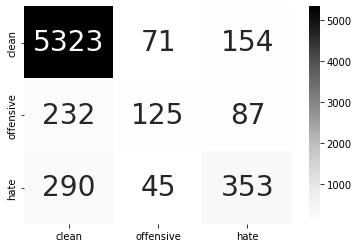

In [ ]:
y_true = pd_prediction['label_id']
y_pred = pd_prediction['label_predict']

f1_micro = f1_score(y_true, y_pred, average='micro')
f1_macro = f1_score(y_true, y_pred, average='macro')
accuracy = accuracy_score(y_true, y_pred)

print(f"F1 - micro: {f1_score}")
print(f"F1 - macro: {f1_macro}")
print(f"Accuracy: {accuracy}")

cf = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf, index = ["clean", "offensive", "hate"], columns = ["clean", "offensive", "hate"])
sn.heatmap(df_cm, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 28})

In [ ]:
est.shutdown()

In [ ]:
print(stats)

Now, the accuracy of this model has reached 98%.

In [ ]:
# Stop orca context when your program finishes
stop_orca_context()

Stopping orca context
